# import Libraries

In [40]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
 
import nltk
en_stop = set(nltk.corpus.stopwords.words('english'))
 
from gensim.models.fasttext import FastText
 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
 
# Lemmatization
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()

# 01)Loading Data

In [41]:
dataset=pd.read_json("../input/yelp-dataset/yelp_academic_dataset_tip.json",lines=True,nrows=10000) 

print(list(dataset))
 
# Check for nulls 
dataset.isnull().sum()

['user_id', 'business_id', 'text', 'date', 'compliment_count']


user_id             0
business_id         0
text                0
date                0
compliment_count    0
dtype: int64

### 1.1)Convert text column into list and subset


In [42]:
sentences  = dataset['text'].tolist()
sentences[0:10]

['Avengers time with the ladies.',
 'They have lots of good deserts and tasty cuban sandwiches',
 "It's open even when you think it isn't",
 'Very decent fried chicken',
 'Appetizers.. platter special for lunch',
 'Chili Cup + Single Cheeseburger with onion, pickle, and relish + Vanilla Coca-Cola...so far.',
 "Saturday, Dec 7th 2013, ride Patco's Silver Sleigh w/ Santa & his elves on a decorated train into Center City. Trains leave from Lindenwold at 10am, 11:15am, & 12:30pm, and make all stops. Great for kids!",
 'This is probably the best place in the cool Springs area to watch a game and eat',
 'Tacos',
 'Starbucks substitute in boring downtown Tampa. Ugh. Never again!']

# 02)Cleaning Data

### ● Remove white extra space from text
### ● Remove all special characters from the text
### ● Remove all single characters from the text
### ● Convert text to lower case
### ● Perform Word tokenization
### ● Lemmatization
### ● Remove stop words from the text
### ● Remove words length less than 3 from text


In [43]:
def process_text(document):
     
            # Remove extra white space from text
        document = re.sub(r'\s+', ' ', document, flags=re.I)
         
        # Remove all the special characters from text
        document = re.sub(r'\W', ' ', str(document))
 
        # Remove all single characters from text
        document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
 
        # Converting to Lowercase
        document = document.lower()
 
        # Word tokenization       
        tokens = document.split()
        
        # Lemmatization using NLTK
        lemma_txt = [stemmer.lemmatize(word) for word in tokens]
        
        # Remove stop words
        lemma_no_stop_txt = [word for word in lemma_txt if word not in en_stop]
        
        # Drop words 
        tokens = [word for word in tokens if len(word) > 3]
                 
        clean_txt = ' '.join(lemma_no_stop_txt)
 
        return clean_txt

In [44]:
clean_data = [process_text(sentence) for sentence in tqdm(sentences) if sentence.strip() !='']
 
word_tokenizer = nltk.WordPunctTokenizer()
tokens = [word_tokenizer.tokenize(sent) for sent in tqdm(clean_data)]
tokens[0:10]

100%|██████████| 10000/10000 [00:00<00:00, 275489.76it/s]


[['avenger', 'time', 'lady'],
 ['lot', 'good', 'desert', 'tasty', 'cuban', 'sandwich'],
 ['open', 'even', 'think'],
 ['decent', 'fried', 'chicken'],
 ['appetizer', 'platter', 'special', 'lunch'],
 ['chili',
  'cup',
  'single',
  'cheeseburger',
  'onion',
  'pickle',
  'relish',
  'vanilla',
  'coca',
  'cola',
  'far'],
 ['saturday',
  'dec',
  '7th',
  '2013',
  'ride',
  'patco',
  'silver',
  'sleigh',
  'santa',
  'elf',
  'decorated',
  'train',
  'center',
  'city',
  'train',
  'leave',
  'lindenwold',
  '10am',
  '11',
  '15am',
  '12',
  '30pm',
  'make',
  'stop',
  'great',
  'kid'],
 ['probably',
  'best',
  'place',
  'cool',
  'spring',
  'area',
  'watch',
  'game',
  'eat'],
 ['taco'],
 ['starbucks', 'substitute', 'boring', 'downtown', 'tampa', 'ugh', 'never']]

# 03)Train fastText word embeddings

In [45]:
from gensim.models import FastText,Word2Vec

In [46]:
embedding_size = 300
window_size = 5
min_word = 5
down_sampling = 1e-2 

fast_text_model = FastText(tokens,
                          vector_size = embedding_size,
                          window = window_size,
                          min_count = min_word,
                          sample = down_sampling,
                          workers = 4,
                          sg = 1,
                          epochs = 100)

In [47]:
fast_text_model.save("ft_model_yelp_tip")

fast_text_yelp = Word2Vec.load("ft_model_yelp_tip")


In [48]:
fast_text_yelp.wv['chicken']

array([-0.01653974, -0.03773461,  0.03464409,  0.36397287, -0.02039647,
       -0.15301096,  0.24778615,  0.00916871,  0.23753437,  0.04151576,
       -0.25973576,  0.20423518,  0.19751629,  0.07944726, -0.81076604,
        0.24295019,  0.6484608 , -0.19346577,  0.40619162, -0.09285652,
        0.23333684, -0.14819239,  0.47561622, -0.87343764,  0.28054005,
        0.09436356,  0.6163917 ,  0.4550687 ,  0.664683  , -0.32979318,
        0.13384   ,  0.02032818, -0.22639307,  0.02965996, -0.68778455,
       -0.3137292 , -0.03755936, -0.65860313,  0.23238325,  0.09492116,
        0.02231728,  0.07025815, -0.04175163, -0.21609792, -0.12629107,
        0.15923826,  0.14595275, -0.21567701, -0.85021067,  0.43311438,
       -0.04952186,  0.40883595, -0.25776017, -0.06186022,  0.08260721,
        0.35837555,  0.19366989,  0.0249474 , -0.68194795, -0.05212419,
       -0.13624516, -0.42034242,  0.36592653,  0.5438809 , -0.04414659,
       -0.25712875,  0.16742678,  0.38056734,  0.07705843,  0.14

In [49]:
fast_text_yelp.wv.similarity('tree','forest')

0.19090495

In [50]:
fast_text_yelp.wv.most_similar(positive=["stop"])

[('stopped', 0.4857913553714752),
 ('top', 0.4363531470298767),
 ('stomach', 0.34962475299835205),
 ('85', 0.3394307792186737),
 ('stone', 0.31769564747810364),
 ('courtyard', 0.3124639391899109),
 ('stout', 0.3117237389087677),
 ('security', 0.30796095728874207),
 ('previous', 0.3032481372356415),
 ('nephew', 0.3023715615272522)]

# 04)visualization FastText word embeddings using tsne

In [51]:

def tsne_plot(for_word, w2v_model):
    
    # trained fastText model dimention
    dim_size = w2v_model.wv.vectors.shape[1]
 
    arrays = np.empty((0, dim_size), dtype='f')
    word_labels = [for_word]
    color_list  = ['red']
 
    # adds the vector of the query word
    arrays = np.append(arrays, w2v_model.wv.__getitem__([for_word]), axis=0)
 
    # gets list of most similar words
    sim_words = w2v_model.wv.most_similar(for_word, topn=10)
 
    # adds the vector for each of the closest words to the array
    for wrd_score in sim_words:
        wrd_vector = w2v_model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
 
    # fit 2d PCA model to the similar word vectors
    model_pca = PCA(n_components = 10).fit_transform(arrays)
 
    # Finds 2d coordinates t-SNE
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(model_pca)
 
    # Sets everything up to plot
    df_plot = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words_name': word_labels,
                       'words_color': color_list})
 
    # plot dots with color and position
    plot_dot = sns.regplot(data=df_plot,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df_plot['words_color']
                                 }
                    )
 
    # Adds annotations with color one by one with a loop
    for line in range(0, df_plot.shape[0]):
         plot_dot.text(df_plot["x"][line],
                 df_plot['y'][line],
                 '  ' + df_plot["words_name"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df_plot['words_color'][line],
                 weight='normal'
                ).set_size(15)
 
 
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
 
    plt.title('t-SNE visualization for word "{}'.format(for_word.title()) +'"')

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


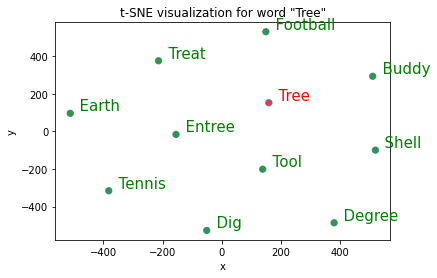

In [59]:
tsne_plot(for_word='tree', w2v_model=fast_text_yelp)